# Introduction

In this notebook we will use the household power consumption dataset to build predictive models of the total active power for each day over the next week(s).

Given that we are interested in total power per day we downsampled the per-minute observations of power consumption to daily totals in the preprocessing step.


In [1]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [2]:
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

# Train and test sets

The first three years of data will be used for training and the final year for evaluating.
The data will be split into standard weeks (from sunday to saturday) which suits our problem framing consisting of predicting the consumption over a week ahead given recent consumption.


In [3]:
dataset.loc['2010']

,Global_active_power
datetime,
2010-01-01,1224.252
2010-01-02,1309.268
2010-01-03,2083.454
2010-01-04,1604.132
2010-01-05,2219.780
...,...
2010-11-22,2041.536
2010-11-23,1577.536
2010-11-24,1796.248


**2010** is the final year of the data. The first Sunday in 2010 was **January 3rd**. The data ends in late November 2010. 
The last Saturday in the data is **November 20th**. This gives **46 weeks** of test data (328 days).

The data starts in **late 2006**. The first Sunday is December 17th. We will have **159 weeks** for training.

In [4]:
def split_dataset(data):
    
    # split into train and test sets working backwards from the test dataset
    train, test = data[1:-328], data[-328:-6]
    
    # split into weeks of data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    
    return train, test

In [5]:
train, test = split_dataset(dataset.values)

print("Train set")
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])

print("Test set")
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

Train set
(159, 7, 1)
3390.46 1309.268
Test set
(46, 7, 1)
2083.454 2197.006


# Framing the supervised learning problem

Models will have as input a one-dimensional subsequence of data containing **n_input** prior days (one or more weeks).
The choice of the size of the sequence (n_input) depends on the application and the model. 

We have 159 training week instances which is not enough to train deep learning models. We will create more training data by using each **n_input** days to predict **n_out** days instead of only using standard weeks.

In [6]:
def to_supervised(n_out=14): #output sequence of 14 days
    
    #flatten the data : number of weeks* 7 days
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    
    X, y = list(), list()
    
    #in_start variable will be used as the beginning index of the sliding window
    in_start = 0
    
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        
        # in_end is the index of the end of the input sequence
        in_end = in_start + n_input
        
        #out_end is the index of the the output sequence
        out_end = in_end + n_out
        
        
        # checking that we have enough data for the output sequence
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            
            X.append(x_input)
            
            y.append(data[in_end:out_end, 0])
            
        # move along one time step
        in_start += 1
        
        
    return array(X), array(y)

# Models

### Vanilla LSTM

We have relatively small amount of data, hence we will build a "small" model.

This model consists of a single hidden LSTM layer with **200 units**, followed by a fully connected layer with **100 nodes** that will interpret the features learned by the LSTM layer. Finally, an output layer will directly predict a vector with **n_out** elements, one for each day in the output sequence.

We will use the **mean squared error** loss function as it is a good match for the RMSE error metric that we will use later to evaluate the models. 

We will use the efficient **Adam** implementation of stochastic gradient descent and fit the model for **100** epochs with a batch size of **16**.

Thestochastic nature of the algorithm means that the same model can learn a slightly different mapping of inputs to outputs each time it is trained. This means results may vary when the model is evaluated.


In [7]:
def vanilla_LSTM():
    
    verbose, epochs, batch_size = 0, 100, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    return model

### Encoder decoder LSTM

We can update the vanilla LSTM to use an encoder-decoder model.
Instead of outputting a vector sequence directly, the model will be comprised of 2 sub-models:
**the encoder** to read and encode the input sequence, and **the decoder** to read the encoded input sequence and make a one-step prediction for each element in the output sequence.


 -  As before, we define an LSTM hidden layer with 200 units for the encoder model which will read the input sequence and will output a 200 element vector (one output per unit) that captures features from the input sequence.
 

 - The internal representation of the input sequence is repeated multiple times, once for each time step in the output sequence. This sequence of vectors will be presented to the LSTM decoder.
 
 
 - We then define the decoder as an LSTM hidden layer with 200 units. The decoder will output the entire sequence, not just the output at the end of the sequence as we did with the encoder. This means that each of the 200 units will output a value for each of the output days, representing the basis for what to predict for each day in the output sequence.
 
 
 - We will then use a fully connected layer to interpret each time step in the output sequence before the final output layer. The output layer predicts a single step in the output sequence, not all seven days at a time, This means that we will use the same layers applied to each step in the output sequence. It means that the same fully connected layer and output layer will be used to process each time step provided by the decoder. This allows the LSTM decoder to figure out the context required for each step in the output sequence and the wrapped dense layers to interpret each time step separately, yet reusing the same weights to perform the interpretation.

In [8]:
def encoder_decoder():
    
    train_y_local=train_y
    verbose, epochs, batch_size = 0, 100, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y_local.shape[1]
    train_y_local = train_y_local.reshape((train_y_local.shape[0], train_y_local.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    
    model.add(RepeatVector(n_outputs))
    
    model.add(LSTM(200, activation='relu', return_sequences=True))
    
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

###  CNN-LSTM Encoder-Decoder Model

A convolutional neural network can be used as the encoder in an encoder-decoder architecture.

The CNN does not directly support sequence input; instead, a 1D CNN is capable of reading across sequence input and learning the features. These can then be interpreted by an LSTM decoder as per normal.

- We will define a simple  CNN architecture for the encoder that is comprised of two convolutional layers followed by a max pooling layer, the results of which are then flattened.
 
 
- The first convolutional layer reads across the input sequence and projects the results onto feature maps. 


- The second performs the same operation on the feature maps created by the first layer, attempting to amplify any salient features. We will use 64 feature maps per convolutional layer and read the input sequences with a kernel size of three time steps.


- The max pooling layer simplifies the feature maps by keeping 1/4 of the values with the largest (max) signal. The distilled feature maps after the pooling layer are then flattened into one long vector that can then be used as input to the decoding process.


- The decoder is the same as was defined in previous sections.

In [9]:
def CNNLSTM():
    
    train_y_local=train_y
    verbose, epochs, batch_size = 0, 100, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y_local.shape[1]
    train_y_local = train_y_local.reshape((train_y_local.shape[0], train_y_local.shape[1], 1))
    
    model = Sequential()
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    model.add(RepeatVector(n_outputs))
    
    model.add(LSTM(200, activation='relu', return_sequences=True))
    
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# Forecasting and evaluating models

In [10]:
n_input = 28
train_x, train_y = to_supervised()

Forecasts are comprised of seven values, one for each day of the week ahead.

It is common with multi-step forecasting problems to evaluate each forecasted time step separately. This is helpful to comment and to constrast models skill at a specific lead times (models good at +1 day vs models good at days +5).


The units of the total power are kilowatts and it would be useful to have an error metric that would also be in the same unit. Both Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) can be used in this case, but RMSE is more commonly used. Unlike MAE, RMSE is more punishing of forecast errors.

The performance metric for this problem will be the RMSE for each lead time from day 1 to day 7.

We will also summarize the performance of a model using a single score in order to compare models overall performance (RMSE across all forecast days).

In [11]:
def forecast(model, history):
    
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    
    input_x = data[-n_input:, 0]
   
    input_x = input_x.reshape((1, len(input_x), 1))
    
    
    yhat = model.predict(input_x, verbose=0)
    
    yhat = yhat[0]
    
    return yhat

In [12]:
def evaluate_forecasts(actual, predicted):
    
    scores = list()
    
    #RMSE score for each day
    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        rmse = sqrt(mse)
        scores.append(rmse)
        
    #overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores


def evaluate_model(build_model):
    
    model = build_model()
    
    history = [x for x in train]
    
    predictions = list()
    for i in range(len(test)):
        
        yhat_sequence = forecast(model, history)
        
        predictions.append(yhat_sequence)
        
        #append real observation to history to predict the next outputs
        history.append(test[i, :])
        
    # evaluate predictions days for each week and overall
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    
    return score, scores

In [13]:
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

#### Vanilla LSTM

LSTM: [405.121] 403.2, 392.0, 370.2, 411.5, 392.7, 357.9, 493.8


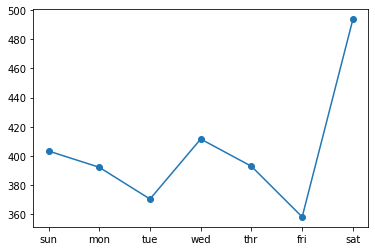

In [14]:
score, scores = evaluate_model(vanilla_LSTM)

summarize_scores('LSTM', score, scores)

days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='LSTM')
pyplot.show()

#### Encoder-Decoder LSTM

Encoder Decoder: [389.054] 403.3, 374.1, 342.7, 382.3, 391.2, 379.9, 442.7


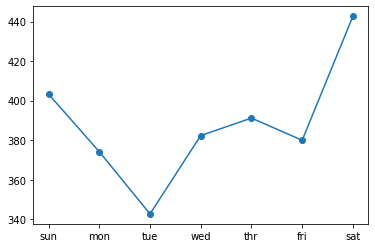

In [15]:
score, scores = evaluate_model(encoder_decoder)

summarize_scores('Encoder Decoder', score, scores)

days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='Encoder decoder')
pyplot.show()

#### CNN-LSTM Encoder-Decoder Model

CNN-LSTM: [381.085] 398.7, 362.4, 341.4, 372.0, 386.5, 333.5, 459.1


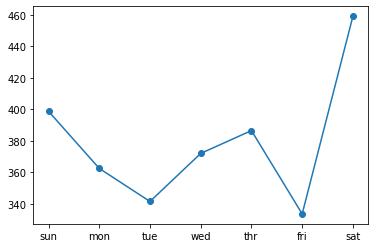

In [16]:
score, scores = evaluate_model(CNNLSTM)

summarize_scores('CNN-LSTM', score, scores)

days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='CNN-LSTM')
pyplot.show()

## Conclusions

- The models have close RMSE values, with CNN-LSTM encoder decoder model being the best out of the three.


- These results change every time we train the models due to their stochastic nature. 


- In this case, Vanilla LSTM model was as performant as the other 2 models, but according to litterature, LSTMs still have problems when dealing with longer sequences, thus the suggestion of enhanced architectures like Stacked LSTMs, Bidirectional LSTMs, CNN-LSTMs, Encoder-Decoder LSTMs etc.


- The architectures are relatively and we can further improve them by finetuning and experimenting with hyper-parameters.

